<a href="https://colab.research.google.com/github/iqbalrez/TSA/blob/main/NLP_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentimen Analisis untuk Twitter

Disusun oleh : 
1.   Michael Hamonangan Sitorus  - 20/460552/TK/51141
2.   M. Iqbal Reza Riandani - 20/460549/TK/51138



Sentiment analysis adalah proses penggunaan text analytics untuk mendapatkan berbagai sumber data dari internet dan beragam platform media sosial. Tujuannya adalah untuk memperoleh opini dari pengguna yang terdapat pada platform tersebut.

Analisis sentimen dalam penelitian ini merupakan proses klasifikasi dokumen tekstual ke dalam dua kelas, yaitu kelas sentimen positif dan negatif menggunakan NER (Named Entity Recognition).  Data opini diperoleh dari jejaring sosial Twitter berdasarkan query dalam Bahasa Inggris. Penelitian ini bertujuan untuk menentukan sentimen publik terhadap objek tertentu yang disampaikan di Twitter dalam bahasa Inggris, sehingga membantu usaha untuk melakukan riset pasar atas opini publik.

###1. Mempersiapkan Data

Menginisiasikan library-library yang akan digunakan

In [ ]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Membuka dan membaca dataset

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

In [ ]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [ ]:
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [ ]:
test.dropna(inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 110.4+ KB


##2. EDA (Exploratory Data Analysis)

EDA akan mempermudah kita dalam melakukan investigasi awal pada data untuk menemukan pola, menemukan anomali, menguji hipotesis, dan memeriksa asumsi dengan bantuan visualisasi (representasi grafis) dari data yang dimiliki

In [ ]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


Berikut menampilkan persebaran dari nilai sentiment data train

In [ ]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


Berikut tampilan Bar Plotnya

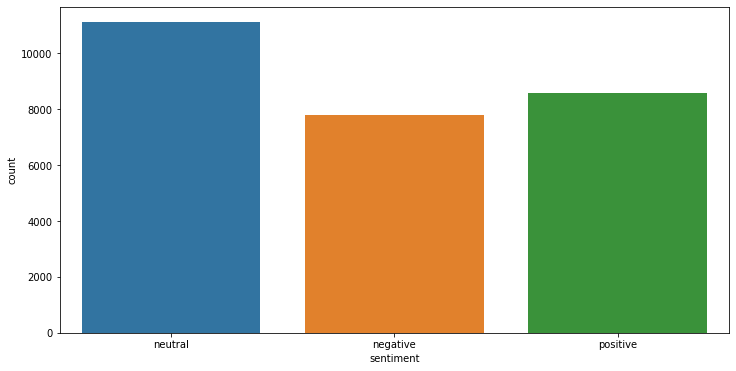

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

####Membuat Meta-Features

Meta_feature yang digunakan adalah nilai Jaccard Similarity antara text and Selected_text

Jaccard Similarity sendiri adalah pengukuran kedekatan umum yang digunakan untuk menghitung kesamaan antara dua objek, seperti dua dokumen teks.


In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST']

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


Berikut adalah distribusi Meta-Features

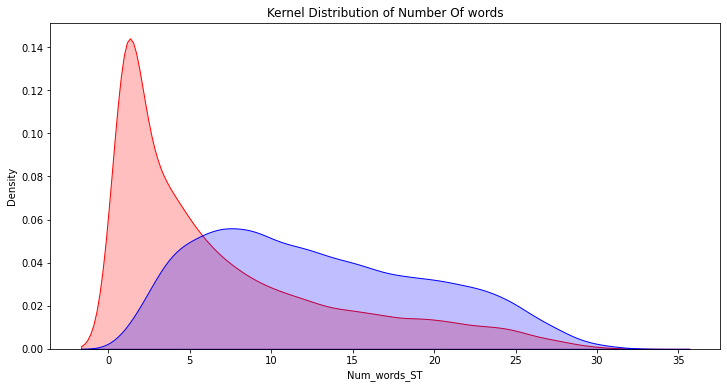

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

Sekarang akan lebih menarik untuk melihat perbedaan jumlah kata dan skor jaccard di berbagai segmen Sentimen

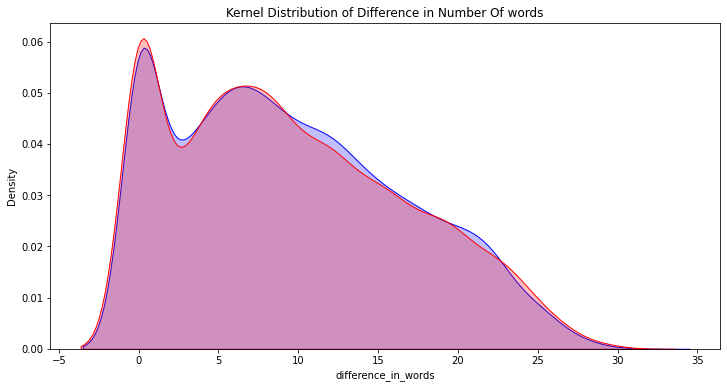

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

Kita dapat melihatnya dengan jelas sekarang, dimana jika kita telah menggunakan fitur di awal maka kita akan tahu bahwa text dan selected_text sebagian besar sama untuk tweets netral

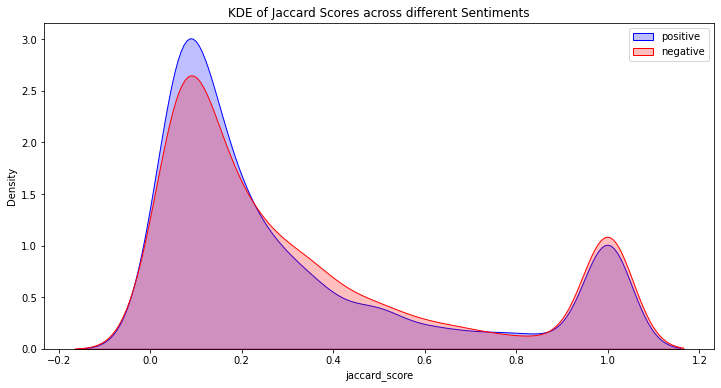

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

Kita bisa melihat beberapa tren menarik dari visualisasi di atas:

1. Tweet positif dan negatif memiliki kurtosis tinggi dan dengan demikian nilainya terkonsentrasi di dua wilayah sempit dan yang berkepadatan tinggi
2. Tweet netral memiliki nilai kurtosis yang rendah dan kepadatannya mendekati nilai 1

**Kesimpulan EDA**

Kita dapat melihat dari plot skor jaccard bahwa nilai puncak untuk plot negatif dan positif berkisar 1. Hal itu menandakan terdapat sekelompok tweet yang memiliki kemiripan yang tinggi antara text dan selected_text

Jika kita dapat menemukan kelompok itu maka kita dapat memprediksi text untuk selected_text untuk tweet tersebut terlepas dari segmen sentimennya

###3. Cleaning

Akan dilakukan cleaning terhadap corpus yang dipakai meliputi :


*   Membuat teks dalam huruf kecil semua (mengganti huruf kapital)
*   Menghilangkan teks yang didalamkurungi
*   Menghilangkan teks yang berupa link
*   Menghilangkan tanda baca
*   Menghilangkan kata yang mengandung angka

In [ ]:
def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


####Quick Analysis

Kita mencari kata yang paling sering muncul dalam target kita yaitu Selected Text

In [ ]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,to,5190
1,I,4842
2,the,4303
3,a,3427
4,my,2503
5,i,2298
6,and,2164
7,you,2072
8,is,1944
9,in,1864


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

*   Kita harus menghilangkan stopwords dalam bahasa inggris. Stopword itu sendiri adalah kata yang diabaikan dalam pemrosesan bahasa alami karena tidak memiliki nilai informasi apapun terhadap sentimen analisis kita nantinya



In [ ]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,I`m,940
2,good,843
3,get,741
4,like,727
5,love,723
6,day,627
7,go,605
8,got,493
9,don`t,489
10,going,488


In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

####Kata yang paling sering muncul berdasarkan Sentiment

In [ ]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

Berikut adalah kata **positif** yang paling sering muncul :

In [ ]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,I,684
1,love,556
2,good,539
3,Happy,371
4,happy,264
5,great,258
6,day,208
7,fun,197
8,nice,192
9,thanks,185


In [ ]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

Berikut adalah kata **negatif** yang paling sering muncul :

In [ ]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,337
2,I`m,243
3,****,231
4,sad,224
5,hate,199
6,bad,192
7,sorry,181
8,like,155
9,don`t,152
10,feel,149


In [ ]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon negative Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

Berikut adalah kata **netral** yang paling sering muncul :

In [ ]:
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,I`m,588
2,get,587
3,go,493
4,like,414
5,-,403
6,got,387
7,going,377
8,work,353
9,know,339
10,day,336


In [ ]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

Kita bisa melihat kata-kata seperti get, go, dont, got, u, cant, lol, like adalah kata yang umum di ketiga segmen. Hal ini menarik karena kata-kata seperti dont dan cant seharusnya lebih bersifat negatif sedangkan kata-kata seperti lol seharusnya lebih bersifat positif. 

Kita akan memiliki lebih banyak wawasan terkait hal ini setelah analisis N-gram

####Unique Words in each Segment

Akan menarik untuk melihat kata-kata yang unik untuk sentimen yang berbeda

In [ ]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split())
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x))

In [ ]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [ ]:
def words_unique(sentiment,numwords,raw_words):
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

Berikut adalah kata unik **positif** yang paling sering muncul :

In [ ]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,"Thanks,",18
1,amazing.,14
2,Lovely,12
3,Moms,11
4,Watched,10
5,thnx,9
6,hilarious,9
7,Goodmorning,8
8,successful,8
9,"sweet,",8


Berikut adalah kata unik **negatif** yang paling sering muncul :

In [ ]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,sad...,11
1,:@,10
2,ugh!,9
3,disappointing,8
4,dead.,8
5,bored...,8
6,hurts!,8
7,sad..,7
8,allergic,7
9,saddest,7


Berikut adalah kata unik **netral** yang paling sering muncul :

In [ ]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,hows,11
1,??????,9
2,???????,8
3,settings,7
4,time?,7
5,Nighty,6
6,mite,6
7,Sat,6
8,try.,6
9,school...,6


Dengan melihat kata-kata unik dari setiap sentimen, sekarang kita memiliki lebih banyak kejelasan tentang data kita. Kata-kata unik ini adalah penentu Sentimen tweets yang sangat kuat

####Building WordCloud

wordcloud berikut adalah gambar yang menunjukkan daftar kata-kata yang digunakan dalam data kita, dimana semakin banyak kata tersebut muncul maka semakin besar ukuran kata tersebut dalam gambar. Wordclouds memberi lebih banyak kejelasan terhadap data yang kita miliki

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

Word Cloud untuk kata-kata pada tiap segmen sentimen kita :

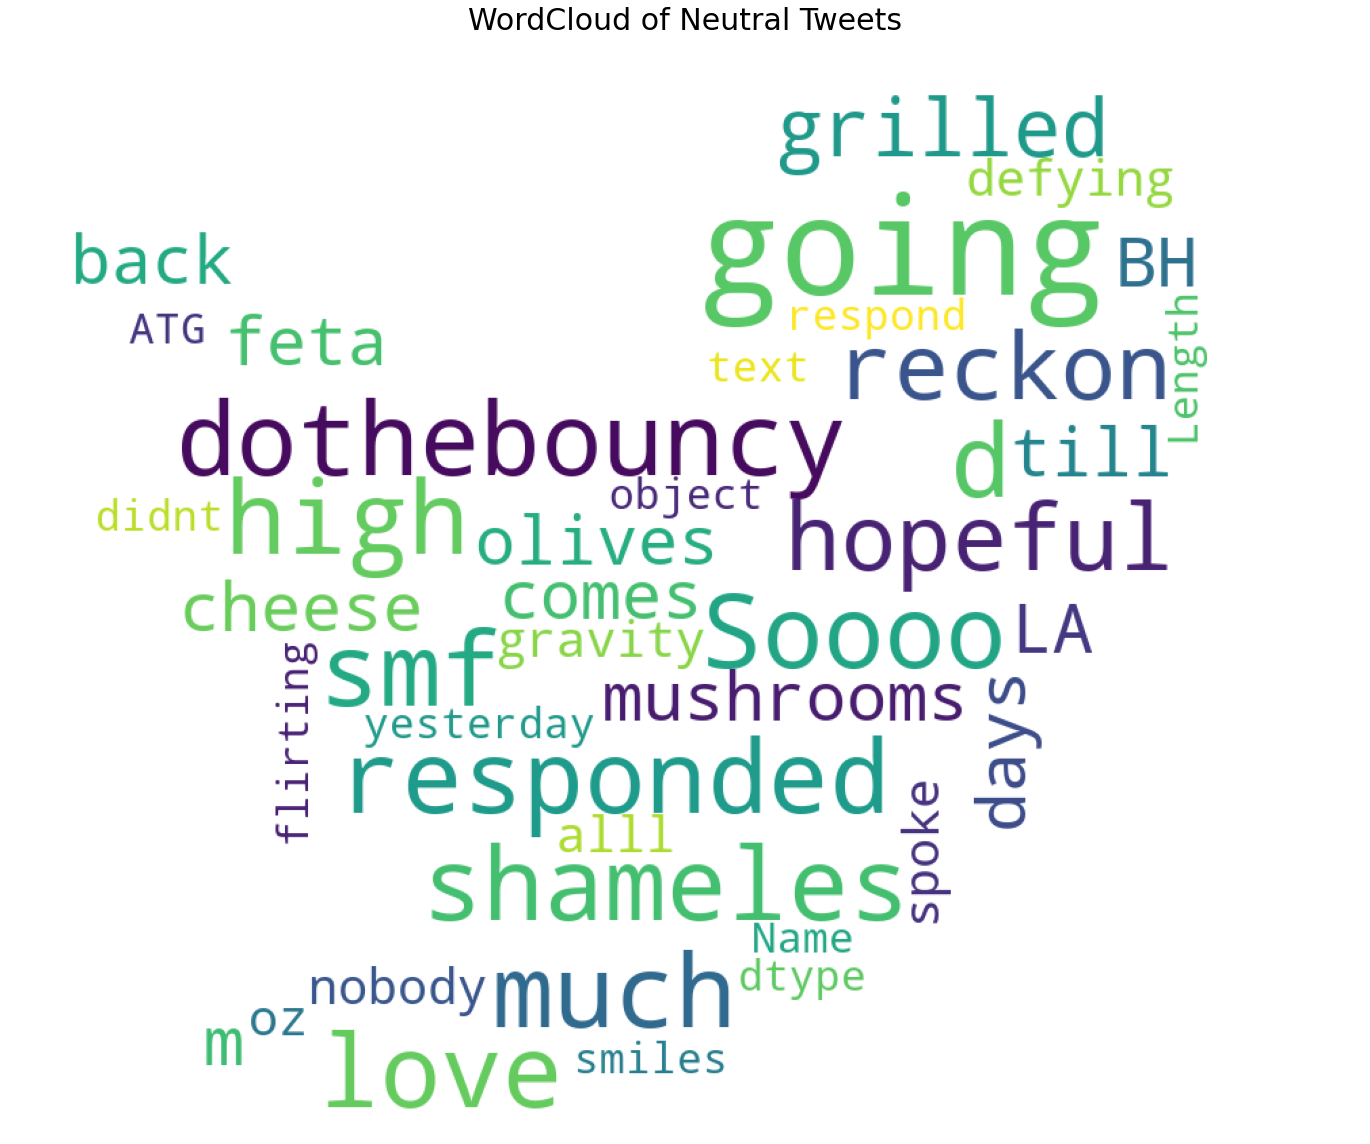

In [ ]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

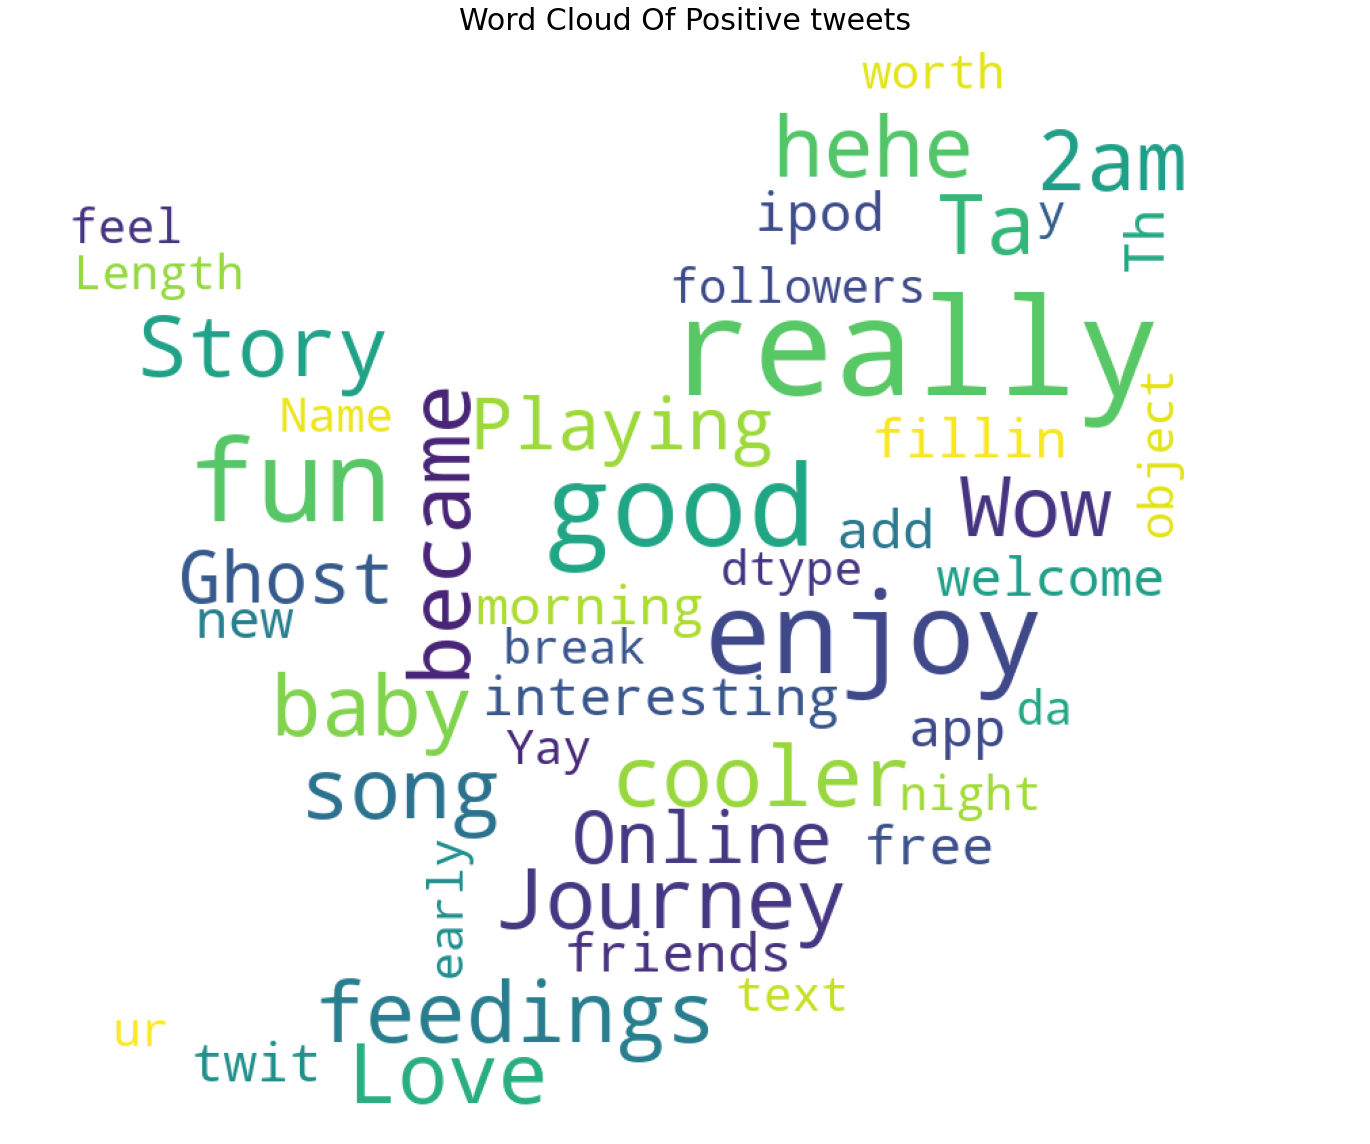

In [ ]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

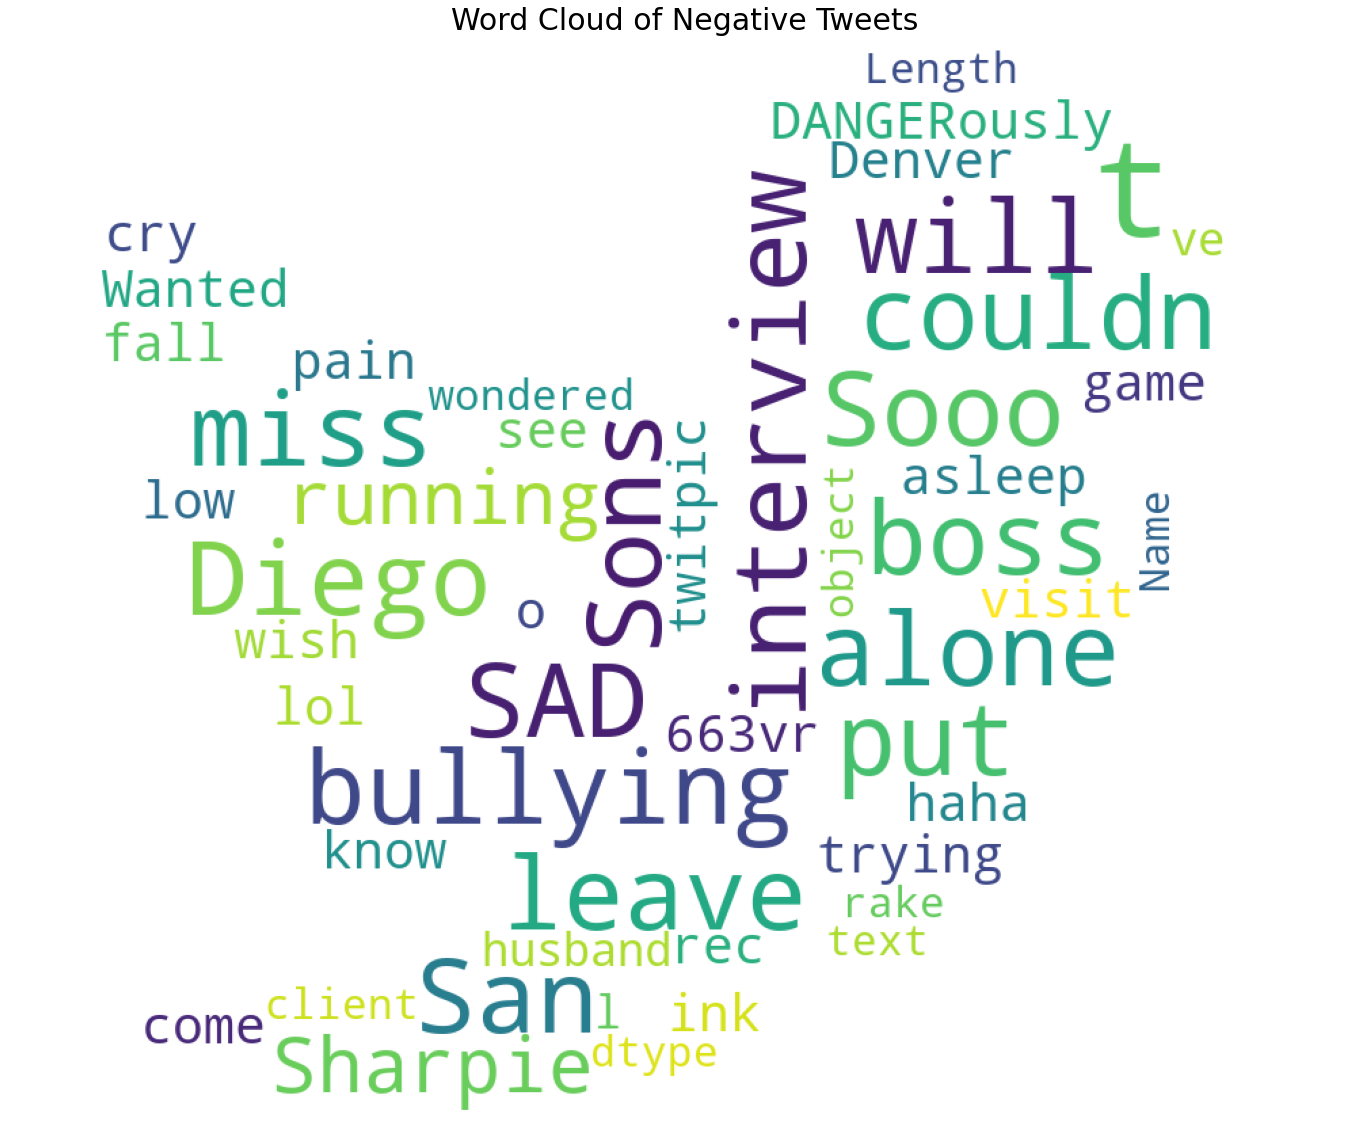

In [ ]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)

###4. Modelling

Permasalahan kita akan dimodelkan dengan
**Named Entity Recognition (NER)**

Named Entity Recognition (NER) adalah permasalahan NLP standar yang melibatkan pencarian entitas berlabel (orang, tempat, organisasi, dll.) dari sepotong teks, lalu mengklasifikasikannya ke dalam serangkaian kategori yang telah ditentukan. 

Akan digunakan spacy untuk membuat model NER pada kasus ini

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [ ]:
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split()))

In [ ]:
df_train = df_train[df_train['Num_words_text']>=3]

Berikut adalah pemodelan NER

In [ ]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [ ]:
from spacy.training.example import Example

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)   
            losses = {}
            for batch in minibatch(train_data, size=compounding(4.0, 500.0, 1.001)):
                example = []
                for texts, annotations in batch:
                  doc = nlp.make_doc(texts)
                  example.append(Example.from_dict(doc, annotations))
                # Update the model
                nlp.update(example, losses=losses, drop=0.3)
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [ ]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    return model_out_path

In [ ]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

Training models untuk tweets bernilai Positif dan Negatif

In [ ]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [00:46<01:33, 46.79s/it]

Losses {'ner': 12479.877073900268}


 67%|██████▋   | 2/3 [01:33<00:46, 46.81s/it]

Losses {'ner': 11261.656717329915}


100%|██████████| 3/3 [02:20<00:00, 46.81s/it]

Losses {'ner': 10985.215960874231}
Saved model to ../working/models/model_pos


In [ ]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [00:44<01:29, 44.86s/it]

Losses {'ner': 12216.311333486234}


 67%|██████▋   | 2/3 [01:29<00:44, 45.00s/it]

Losses {'ner': 10968.961245206177}


100%|██████████| 3/3 [02:14<00:00, 44.94s/it]

Losses {'ner': 10613.928687280353}
Saved model to ../working/models/model_neg


Training model telah selesai dilakukan

###5. Memprediksi dengan Model yang Telah Dibuat

In [ ]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

Testing data diambil dengan metode scraping, yaitu mengambil data dari website tweeter. 

In [ ]:
selected_texts = []
MODELS_BASE_PATH = '/working/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  /working/models/


In [ ]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Good
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!
5,726e501993,that`s great!!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my..."
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...


Diatas adalah output data, untuk lebih jelasnya predicting dengan model NER kita dapat dilihat dari tabel dibawah ini

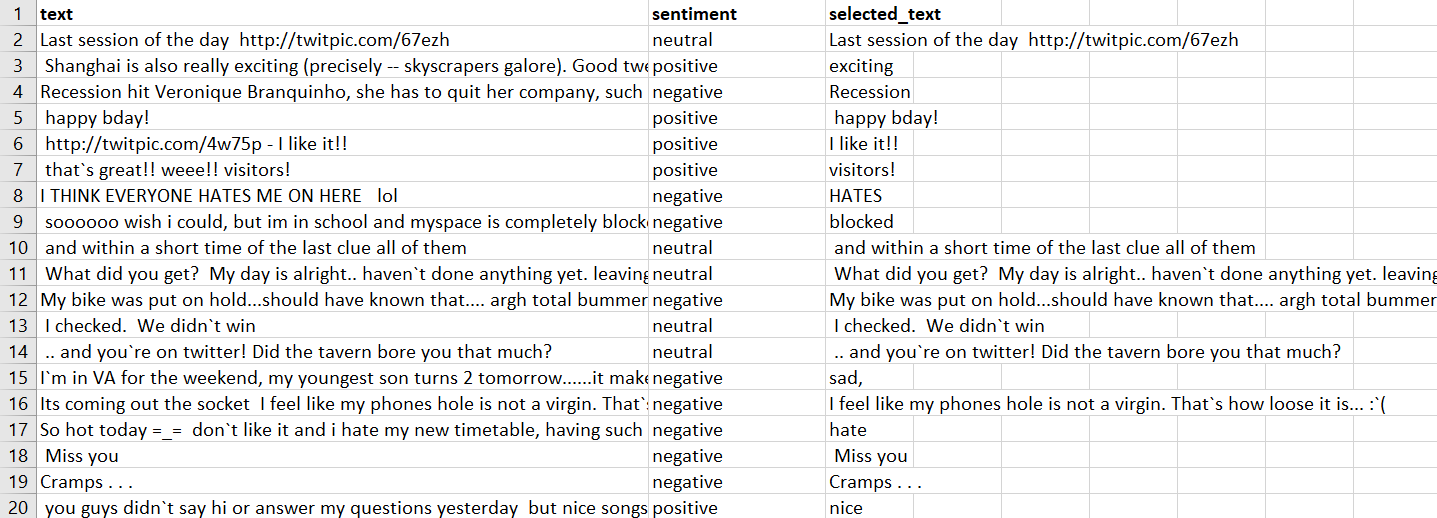

1.   Terlihat bahwa untuk data yang dideteksi oleh model sebagai '*neutral*' oleh model, maka selected_text tetap akan memiliki bentuk yang sama dengan text aslinya
2.   Untuk text yang dideteksi oleh model sebagai '*positive*' dan '*negative*', maka selected_text akan diubah ke bentuk kata atau suku kata (tidak lebih dari 3 kata) yang mengandung nilai sentimen dari kalimat tersebut.





###6. Kesimpulan

Keluaran dari model ini adalah hasil data tweets yang telah diklasifikasikan menurut nilai sentimennya yaitu netral, positif, ataupun negatif. Kemudian teks bernilai positif dan negatif akan disederhanakan menjadi sebuah suku kata (kurang dari 3 kata) yang mengandung nilai sentimen dari teks tersebut untuk mempermudah analisis kedepannya.

Kiranya output ini menghasilkan data analitik baru yang dapat bermanfaat dalam tindakan atau proyek lebih lanjut berdasarkan tweets yang dilakukan masyarakat